<a href="https://colab.research.google.com/github/alirezaghl/Architectures/blob/main/Convolutional_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import transforms as tt
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [139]:
trainset = torchvision.datasets.MNIST('./', download=True, train = True,
                                      transform = tt.ToTensor())
testset = torchvision.datasets.MNIST('./', download=True, train = False,
                                     transform = tt.ToTensor())

In [140]:
train_dl = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = 128,
    shuffle = True
)

test_dl = torch.utils.data.DataLoader(
    dataset = testset,
    batch_size = 256,
    shuffle = True
)

In [4]:
img, _ = next(iter(train_dl))
img.shape

torch.Size([128, 1, 28, 28])

Variational Autoencoders have two parts, the encoder and the decoder. The size of the the output from the last convolutional layer of the encoder is $(128,7,7)$. So the image size is reduced from $28*28$ to $7*7$ and the number of channels now is $128$. Then we convert the output to a one dimensional vector. The laste layer of the encoder predicts two vector : the mean and the variance, I choose $64$ for the latent space dimension. Using these two vectors, the normal distribution is randomly sampled to return the encoder output.
Intuitively, The purpose of introducing the new parameter $epsilon$ is to enable us to perform backprop. The decoder should do the reverse : accept an input vector of length $64$, and return a result of shape $(28, 28)$.\
The decoder output is a vector sized $(1*29*29)$ and this is the reason for trimming it.

In [156]:
class VAE(nn.Module):
  def __init__(self):                               # 6272
    super(VAE, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, stride = 1, padding = 1, kernel_size = 3 )
    self.conv2 = nn.Conv2d(32, 64, stride = 2, padding = 1, kernel_size = 3 )
    self.conv3 = nn.Conv2d(64, 128, stride = 2, padding = 1, kernel_size = 3 )
    self.conv4 = nn.Conv2d(128, 128, stride = 1, padding = 1, kernel_size = 3 )
    self.fc_mean = nn.Linear(6272, 64)
    self.fc_log_var = nn.Linear(6272, 64)

    self.fc3 = nn.Linear(64, 6272)
    self.convT1 = nn.ConvTranspose2d(128, 128, stride = 1, kernel_size = 3, padding = 1)
    self.convT2 = nn.ConvTranspose2d(128, 64, stride = 2, kernel_size = 3, padding = 1)
    self.convT3 = nn.ConvTranspose2d(64, 32, stride = 2, kernel_size = 3, padding = 0)
    self.convT4 = nn.ConvTranspose2d(32, 1, stride = 1, kernel_size = 3, padding = 0)

  def encoder(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = x.view(-1, 128*7*7)
    mu = self.fc_mean(x)    
    log_var = self.fc_log_var(x) 
    return mu, log_var

  def reparameterize(self, mu, logvar):
    std = torch.exp(logvar/2) 
    eps = torch.randn_like(std) 
    return mu + std * eps
         
  def decoder(self, z):
    x = self.fc3(z)
    x = x.view(-1, 128, 7, 7)
    x = F.relu(self.convT1(x))
    x = F.relu(self.convT2(x))
    x = F.relu(self.convT3(x))
    x = torch.sigmoid(self.convT4(x))
    x = x [:, :, :28, :28]          #Trimming
    return x
    
  def forward(self, x):
    mu, log_var = self.encoder(x)
    z = self.reparameterize(mu, log_var)
    out = self.decoder(z)
    return out, mu, log_var

variational = VAE().to('cuda')

In [157]:
optimizer = torch.optim.Adam(variational.parameters(), lr=1e-3) 

To sample from a wider range of latent variables, KL divergence is added to improve the similarity between the latent variable distribution and the gaussian distribution.

In [158]:
def loss_function(out, y, mu, logvar):
    BCE = F.binary_cross_entropy(
    out, y, reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD

In [159]:
epochs = 50
img_list = []

for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  
        variational.train()
        train_loss = 0
        for img, _ in train_dl:
            img = img.to('cuda')
            
            output, mu, logvar = variational(y)
            loss = loss_function(output, img, mu, logvar)
            train_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_dl.dataset):.4f}')

        with torch.no_grad():
          variational.eval()
          for img, _ in test_dl:
            img = img.to('cuda')
            reconstruct, mu, logvar = variational(img)
            img_list.append(vutils.make_grid(reconstruct, padding=2, normalize=True))

====> Epoch: 1 Average loss: 152.4944
====> Epoch: 2 Average loss: 107.0053
====> Epoch: 3 Average loss: 103.5841
====> Epoch: 4 Average loss: 102.0825
====> Epoch: 5 Average loss: 100.9813
====> Epoch: 6 Average loss: 100.2887
====> Epoch: 7 Average loss: 99.6387
====> Epoch: 8 Average loss: 99.1775
====> Epoch: 9 Average loss: 98.6838
====> Epoch: 10 Average loss: 98.3299
====> Epoch: 11 Average loss: 97.9857
====> Epoch: 12 Average loss: 97.6623
====> Epoch: 13 Average loss: 97.4229
====> Epoch: 14 Average loss: 97.1823
====> Epoch: 15 Average loss: 96.9801
====> Epoch: 16 Average loss: 96.7850
====> Epoch: 17 Average loss: 96.6460
====> Epoch: 18 Average loss: 96.3690
====> Epoch: 19 Average loss: 96.2041
====> Epoch: 20 Average loss: 96.0233
====> Epoch: 21 Average loss: 95.8715
====> Epoch: 22 Average loss: 95.8297
====> Epoch: 23 Average loss: 95.6380
====> Epoch: 24 Average loss: 95.5170
====> Epoch: 25 Average loss: 95.4018
====> Epoch: 26 Average loss: 95.3040
====> Epoch: 27

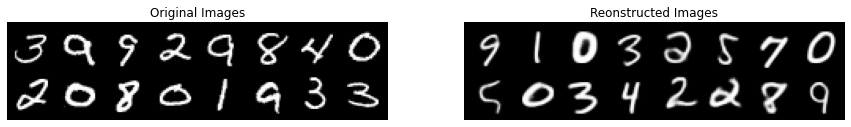

In [163]:
real_batch = next(iter(train_dl))

# Plot the original images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Original Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:16], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the reconstructed images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Reonstructed Images")
plt.imshow(np.transpose(img_list[-1].cpu(),(1,2,0)))
#plt.show()